### Matrix indexing: Modulo Operator vs Floor Division

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib widget
plt.ioff()

def plot_sets(ax,gr=False,ti='',xla=False,yla=False,zla=False,xli=False,yli=False,zli=False,ticks_off=False,xticks_off=False,yticks_off=False,zticks_off=False, ba=False, ar=False,leg=False,view=False):
    
    ax.set_title(ti)
    if gr:  ax.grid(gr);ax.set_axisbelow(True)
    if xla: ax.set_xlabel(xla)
    if yla: ax.set_ylabel(yla)
    if zla: ax.set_zlabel(zla)

    if xticks_off: ax.set_xticklabels([])
    if yticks_off: ax.set_yticklabels([])
    if zticks_off: ax.set_zticklabels([])

    if   ticks_off==1: ax.set_xticklabels([]); ax.set_xticks([]);ax.set_yticklabels([]); ax.set_yticks([])
    elif ticks_off==2: ax.set_xticklabels([]); ax.set_xticks([])
    elif ticks_off==2: ax.set_yticklabels([]); ax.set_yticks([])

    if ba: ax.set_box_aspect(ba)
    if ar: ax.set_aspect(ar)

    if xli: ax.set_xlim(xli)
    if yli: ax.set_ylim(yli)
    if zli: ax.set_zlim(zli)

    if leg: ax.legend(**leg)

    if view:ax.view_init(**view)

SMALL_SIZE  = 8
MEDIUM_SIZE = 10

# title
plt.rc('axes',titlesize=MEDIUM_SIZE,titleweight='bold')
# xy-labells
plt.rc('axes',labelsize=SMALL_SIZE)
# xy-ticks
plt.rc('xtick',labelsize=SMALL_SIZE)
plt.rc('ytick',labelsize=SMALL_SIZE)
    
px2inch = 1/plt.rcParams['figure.dpi']

In [2]:
# Control pts P
# P = [x1,y1
#      x2,y2
#      x3,y3
#      xn,yn]

# Poly grade = nºpts-1 = P.shape[0]-1

def Binomial(n,i):    
    return math.factorial(n) / ( math.factorial(i)*math.factorial(n-i) )

def Bernstain(n,i,t): 
    return Binomial(n,i) * t**i * (1-t)**(n-i)

def Berstein_Mat(n):
    M = np.zeros((n+1,n+1))
    for i in range(n+1):
        for j in range(n+1):
            if j<=n-i: M[i,j] = Binomial(n,i)*Binomial(n-i,j)*(-1)**(n+i-j)
    return np.flipud(M)

def Bezier_loop(P,nt=50):
    n  = P.shape[0]-1 
    B  = []
    for t in np.linspace(0,1,nt):
        Bi = np.zeros(2)
        for i,Pi in enumerate(P):
            Bi += Pi*Bernstain(n,i,t)
        B.append([Bi])
    return np.concatenate(B,axis=0)

def Bezier_mat(P,nt=50):
    n     = P.shape[0]-1 
    M     = Berstein_Mat(n)
    t     = np.linspace(0,1,nt).reshape(-1,1)
    pow   = np.arange(n+1)
    pow,_ = np.meshgrid(pow,t)
    T     = (t*np.ones((1,n+1)))**pow
    return T@M@P

def Bezier_mat2(P,t):
    n     = P.shape[0]-1 
    M     = Berstein_Mat(n)
    t     = t.reshape(-1,1)
    pow   = np.arange(n+1)
    pow,_ = np.meshgrid(pow,t)
    T     = (t*np.ones((1,n+1)))**pow
    return T@M@P

def cumulative_dis(B):
    # B = (nt,2) bezier points
    cum_dis = np.cumsum( np.sqrt( np.sum(np.diff(B,axis=0)**2,axis=1) ) )
    return  np.insert(cum_dis, 0, 0) 


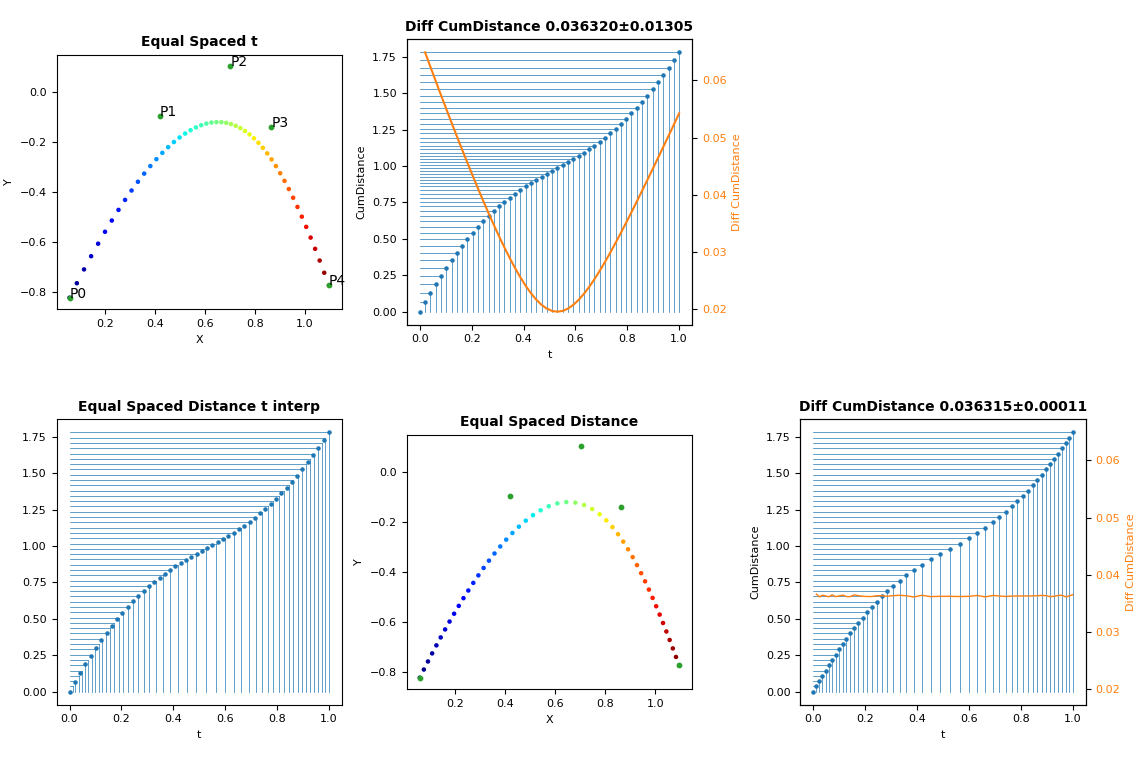

In [3]:
plt.close('all')

# Calc random control points
n    = 4    # poly grade
npts = n+1  # n pts

Px = +np.linspace(0,1,npts).reshape(-1,1)
Py = -np.linspace(-1,1,npts).reshape(-1,1)**2
P  =  np.concatenate((Px,Py),axis=1) + np.random.rand(npts,2)*0.25

# Px = np.arange(npts).reshape(-1,1)
# Py = np.random.randn(npts,1)*2
# P  = np.concatenate((Px,Py),axis=1) 

# Computed bezier with equal spaced t
nt  = 50
B1  = Bezier_mat(P,nt=nt) #B2 = Bezier_loop(P,nt=nt)
dis = cumulative_dis(B1)
dis_max = dis[-1]

# Obtain a non-uniform time vector that guarantees uniform spacing
t         = np.linspace(0,1,nt)
dis_equal = np.linspace(0,dis_max,nt)
t_interp  = np.interp(dis_equal,dis,t)

# Obtain new Bezier equal spaced points
B3   = Bezier_mat2(P,t_interp)
dis2 = cumulative_dis(B3)


size_plot = 380
size_mark = 5
layout = [[0,1,5],
          [2,3,4]]

fig, ax = plt.subplot_mosaic(layout,constrained_layout=True,figsize=(3*size_plot*px2inch,2*size_plot*px2inch))
fig.canvas.toolbar_position = 'right'
fig.canvas.header_visible   = False

ax[5].set_axis_off()

# Subplot 1
##############
ax[0].scatter(B1[:,0],B1[:,1],marker='o',c=t,cmap='jet',s=size_mark  ) # Bezier  Matrix
ax[0].scatter(P[:,0],P[:,1]  ,marker='o',c='tab:green'  ,s=2*size_mark) # Control Points

for i,(px,py) in enumerate(P):ax[0].text(px,py,f'P{i}')
plot_sets(ax[0],xla='X',yla='Y',ar=1,ti=f'Equal Spaced t')

# Subplot 2
##############
diff_dis = np.diff(dis)
color    = 'tab:orange'
ax1 = ax[1].twinx()
ax1.set_ylabel('Diff CumDistance', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(t[1:],diff_dis,c=color)
max_dis = np.max(diff_dis)
min_dis = np.min(diff_dis) 
lim_dis = np.array([min_dis,max_dis]) + np.array([-1,1])*(max_dis-min_dis)*0.05
ax1.set_ylim(lim_dis)

for ti,di in zip(t,dis):
    ax[1].plot([ti,ti],[0,di],'tab:blue',lw=0.5)
    ax[1].plot([0,ti],[di,di],'tab:blue',lw=0.5)

ax[1].scatter(t,dis,marker='o',c='tab:blue',s=size_mark)
plot_sets(ax[1],xla='t',yla='CumDistance',ti=f'Diff CumDistance {np.mean(np.diff(dis)):0.6f}±{np.std(np.diff(dis)):0.5f}',ba=1)

# Subplot 3
##############
for ti,di in zip(t_interp,dis_equal):
    ax[2].plot([ti,ti],[0,di],'tab:blue',lw=0.5)
    ax[2].plot([0,ti],[di,di],'tab:blue',lw=0.5)

ax[2].scatter(t,dis,marker='o',c='tab:blue',s=size_mark)
plot_sets(ax[2],xla='t',ti=f'Equal Spaced Distance t interp',ba=1)

# Subplot 4
##############
ax[3].scatter(B3[:,0],B3[:,1],marker='o',c=t_interp,cmap='jet',s=size_mark  ) # Bezier  Matrix
ax[3].scatter(P[:,0],P[:,1]  ,marker='o',c='tab:green',s=2*size_mark) # Control Points
plot_sets(ax[3],xla='X',yla='Y',ar=1,ti=f'Equal Spaced Distance')


# Subplot 5
##############
color    = 'tab:orange'
ax3 = ax[4].twinx()
ax3.set_ylabel('Diff CumDistance', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.plot(t_interp[1:],np.diff(dis2),lw=1,c=color,zorder = -100)
ax3.set_ylim(lim_dis)

for ti,di in zip(t_interp,dis2):
    ax[4].plot([ti,ti],[0,di],'tab:blue',lw=0.5)
    ax[4].plot([0,ti],[di,di],'tab:blue',lw=0.5)

ax[4].scatter(t_interp,dis2,marker='o',c='tab:blue',s=size_mark)
plot_sets(ax[4],xla='t',yla='CumDistance',ti=f'Diff CumDistance {np.mean(np.diff(dis2)):0.6f}±{np.std(np.diff(dis2)):0.5f}',ba=1)

plt.show()

In [4]:
# %timeit Bezier_loop(P)
# %timeit Bezier_mat(P)